In [1]:
%load_ext autoreload

In [2]:
autoreload 2

In [3]:
%matplotlib inline

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import seaborn as sn
sn.set_style("whitegrid")

import inputs
import models
import shooting

import operator
from scipy.interpolate import interp1d

from __future__ import division

# Calibrating the Adamopoulos and Restuccia(2014) paper with $x$, exponential version

This notebook solves for a model with two-sided heterogeneity and firm size when capital also enters the production function.

In particular, the production function takes the form:

$$F(x,y,l,r,k) = rA\kappa ( k^{\rho} \eta + (1-\eta) (y(l/r)^{x})^{\rho})^{\gamma/\rho}$$

The solution for optimal capital ($k^{*}(x,y,l,r)$) can be found in the New Capital.ipynb notebook.

First, workers and firms are created - we assume worker skill is very homogeneous, and that firm skill follows a lognormal distribution.

Then the model is solved for Rich ($A=1,R=0.13099$) and Poor ($A=0.5105,R=0.83684$) countries and then comapres the solution.

In [91]:
# define some workers skill
x, a, b = sym.var('x, a, b')
skill_cdf = 4.2*((x - a) / (b - a))
skill_params = {'a': 0.99, 'b': 1.01}
skill_bounds = [skill_params['a'], skill_params['b']]

workers = inputs.Input(var=x,
                       cdf=skill_cdf,
                       params=skill_params,
                       bounds=skill_bounds,
                       )

# define some firms lognorm.pdf(x, s) = 1 / (s*x*sqrt(2*pi)) * exp(-1/2*(log(x)/s)**2)
y, loc2, mu2, sigma2 = sym.var('y, loc2, mu2, sigma2')
productivity_cdf = 0.5 + 0.5 * sym.erf((sym.log(y - loc2) - mu2) / sym.sqrt(2 * sigma2**2))
productivity_params = {'loc2': 1e0, 'mu2': 0.0, 'sigma2': 1.0}
productivity_bounds = (1.2, 1e1)

firms = inputs.Input(var=y,
                     cdf=productivity_cdf,
                     params=productivity_params,
                     bounds=productivity_bounds,
                     )

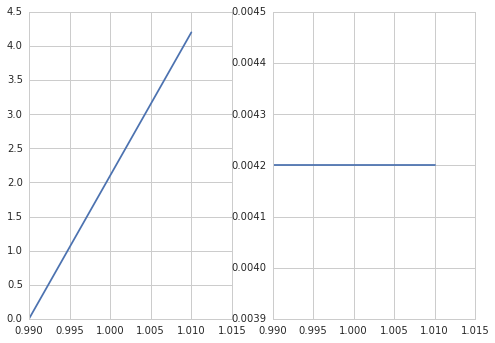

In [145]:
xt = np.linspace(0.99,1.01,1000)
plt.subplot(1,2,1)
plt.plot(xt,4.2*((xt - 0.99) / (1.01 - 0.99)))

plt.subplot(1,2,2)
plt.plot(xt, np.ones(len(xt)) * 4.2/len(xt) )

plt.show()

## 1.Solving for the Rich Country

In [92]:
# Developped country

R, l, r, rho, gamma, eta, L, A, kapa = sym.var('R, l, r, rho, gamma, eta, L, A, kapa')

# First set k to the optimum (look at Capital notebook)
k_star = (2*6**(-0.5)*(r*A*eta**2*kapa/R)**0.5*sym.cos(0.333333333333333*sym.acos(3*6**0.5*((l/r)**x*y)**0.25*(R/(r*A*eta**2*kapa))**0.5*(-eta + 1)/(2*eta))))**(4)

F = r*A*kapa*(eta*(k_star)**rho + (1- eta)*(((l/r)**x)*y)**rho)**(gamma/rho)

k_star2 = 16*6**(-2.0)*(A*eta**2*kapa*r/R)**2.0*sym.cosh(0.333333333333333*sym.acosh(3*6**0.5*(y*(l/r)**x)**0.25*(R/(A*eta**2*kapa*r))**0.5*(-eta + 1)/(2*eta)))**4

F2 = r*A*kapa*(eta*(k_star2)**rho + (1- eta)*(((l/r)**x)*y)**rho)**(gamma/rho)

F_params = {'R':0.13099, 'rho':0.25, 'gamma':0.5, 'eta':0.89, 'L':4.2, 'A': 1.0, 'kapa':1.0}

In [93]:
model = models.Model(assortativity='positive',
                     workers=workers,
                     firms=firms,
                     production=F,
                     params=F_params)

solver = shooting.ShootingSolver(model=model)

In [94]:
solver.solve(100.0, tol=1e-6, number_knots=6000, knots=None, integrator='lsoda', message=True)

Exhausted workers: initial guess of 50.0 for firm size is too high!
Exhausted workers: initial guess of 25.0 for firm size is too high!
Exhausted workers: initial guess of 12.5 for firm size is too high!
Exhausted firms: initial guess of 6.25 for firm size is too low.
Exhausted workers: initial guess of 9.375 for firm size is too high!
Exhausted workers: initial guess of 7.8125 for firm size is too high!
Exhausted workers: initial guess of 7.03125 for firm size is too high!
Exhausted workers: initial guess of 6.640625 for firm size is too high!
Exhausted workers: initial guess of 6.4453125 for firm size is too high!
Exhausted firms: initial guess of 6.34765625 for firm size is too low.
Exhausted firms: initial guess of 6.396484375 for firm size is too low.
Exhausted workers: initial guess of 6.4208984375 for firm size is too high!
Exhausted workers: initial guess of 6.40869140625 for firm size is too high!
Exhausted firms: initial guess of 6.40258789062 for firm size is too low.
Exhaus

In [95]:
solver.solution

,$\mu(x)$,$\theta(x)$,$w(x)$,$\pi(x)$
x,,,,
0.990000,1.200001,3.876600,0.052624,2.976948
0.990003,1.200331,3.876840,0.052625,2.976999
0.990007,1.200661,3.877079,0.052627,2.977049
0.990010,1.200991,3.877318,0.052629,2.977100
0.990013,1.201320,3.877556,0.052631,2.977150
0.990017,1.201649,3.877795,0.052633,2.977200
0.990020,1.201978,3.878032,0.052635,2.977251
0.990023,1.202306,3.878270,0.052636,2.977301
0.990027,1.202634,3.878507,0.052638,2.977351


In [96]:
sol1 = solver.solution
xs = sol1.index.values
ys = sol1['$\\mu(x)$'].values
thetas = sol1['$\\theta(x)$'].values
ws = sol1['$w(x)$'].values

# For capital lambdify k_star
eval_k = sym.lambdify((x,y,l,r,A,kapa,eta,R), k_star)
ks = []
for a in range(len(xs)):
    ks.append(eval_k(xs[a],ys[a],thetas[a],1,1,1,0.89,0.13099))
ks = np.array(ks)

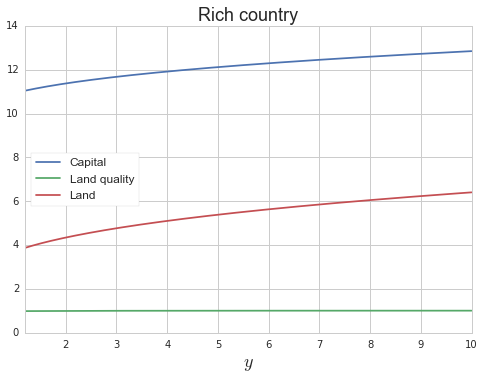

In [97]:
# Plotting the solution
plt.plot(ys, ks, label="Capital")
plt.plot(ys, xs, label="Land quality")
plt.plot(ys, thetas, label="Land")
plt.legend(loc='best', frameon=True, fontsize=12)
plt.xlim(min(ys), max(ys))
plt.xlabel('$y$', fontsize=18)
plt.title("Rich country", fontsize=18)
plt.show()

In [146]:
def pdf_workers(xs):
    return np.ones(len(xs))*(4.2/len(xs))

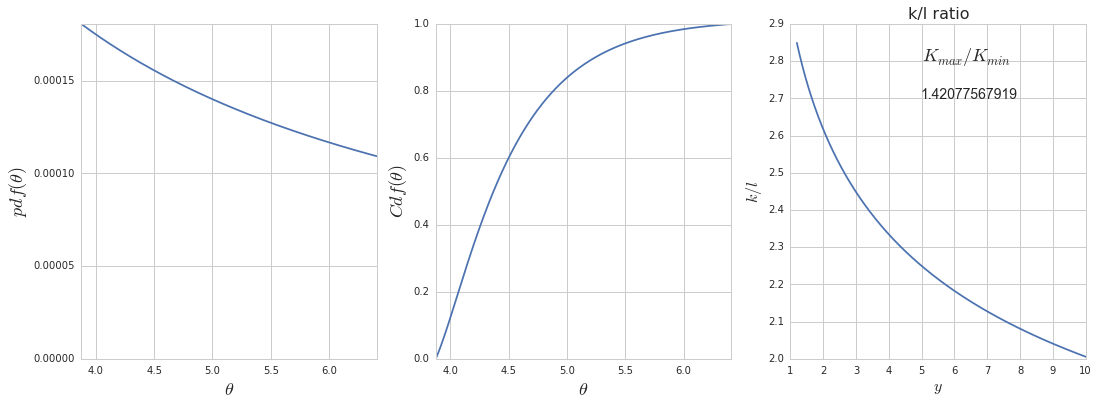

In [147]:
# # # # Firm size distribution # # # # 
pdf_theta_hat = pdf_workers(xs)/thetas

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(thetas,pdf_theta_hat)
plt.ylabel('$pdf(\\theta)$', fontsize=18)
plt.xlabel('$\\theta$', fontsize=18)
plt.xlim(min(thetas), max(thetas))
plt.ylim(0,max(pdf_theta_hat))

plt.subplot(1,3,2)
cdf_theta_hat = np.cumsum(pdf_theta_hat)/sum(pdf_theta_hat)
plt.plot(thetas,cdf_theta_hat)
plt.ylabel('$Cdf(\\theta)$', fontsize=18)
plt.xlabel('$\\theta$', fontsize=18)
plt.xlim(min(thetas), max(thetas))

k_ratio = ks/thetas
plt.subplot(1,3,3)
plt.plot(ys,k_ratio)
plt.xlabel('$y$', size=16)
plt.ylabel('$k/l$', fontsize=16)
plt.title('k/l ratio', fontsize=16)
plt.annotate(str(max(k_ratio)/min(k_ratio)), (5,2.7), fontsize=14)
plt.annotate('$K_{max}/K_{min}$', (5,2.8), fontsize=18)

plt.show()

## 2.Solving for the Poor Country

In [120]:
F_params2 = {'R':0.83684, 'rho':0.25, 'gamma':0.5, 'eta':0.89, 'L':5.46, 'A': 0.5105, 'kapa':1.0}

k_star2 = 16*6**(-2.0)*(A*eta**2*kapa*r/R)**2.0*sym.cosh(0.333333333333333*sym.acosh(3*6**0.5*(y*(l/r)**x)**0.25*(R/(A*eta**2*kapa*r))**0.5*(-eta + 1)/(2*eta)))**4

F2 = r*A*kapa*(eta*(k_star2)**rho + (1- eta)*(((l/r)**x)*y)**rho)**(gamma/rho)

model = models.Model(assortativity='positive',
                     workers=workers,
                     firms=firms,
                     production=F,
                     params=F_params)

solver = shooting.ShootingSolver(model=model)

model2 = models.Model('positive',
                     workers=workers,
                     firms=firms,
                     production=F,
                     params=F_params2)

solver = shooting.ShootingSolver(model=model2)

In [121]:
solver.solve(100.0, tol=1e-6, number_knots=1000, knots=None, integrator='lsoda', message=True)

AssertionError: Wage should be non-negative!

In [51]:
solver.solution

ValueError: Shape of passed values is (1, 5), indices imply (5, 5)

In [ ]:
sol2 = solver.solution

xs2 = sol2.index.values
ys2 = sol2['$\\mu(x)$'].values
thetas2 = sol2['$\\theta(x)$'].values
ws2 = sol2['$w(x)$'].values

ks2 = []
for a in range(len(xs2)):
    ks2.append(eval_k(xs2[a],ys2[a],thetas2[a],1,0.5105,1,0.89,0.83684))

In [ ]:
plt.plot(ys2, ks2, label="Capital")
plt.plot(ys2, xs2, label="Land quality")
plt.plot(ys2, thetas2, label="Land")
plt.legend(loc='best')
plt.xlim(0.0,0.2)
plt.ylim(0.0,10.0)
plt.title("Poor country")
plt.show()

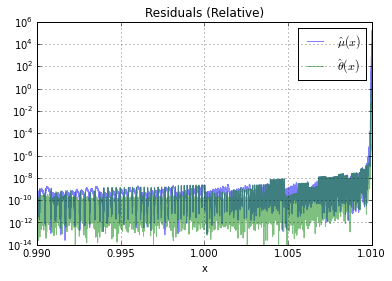

In [23]:
# Plotting the residuals
solver.residuals.plot(logy=True, alpha=0.5)
plt.title("Residuals (Relative)")
plt.show()

## 3. Comparing Solutions

### All graphs have in the horizontal axis *farmer skill* ($y$)

Solutions

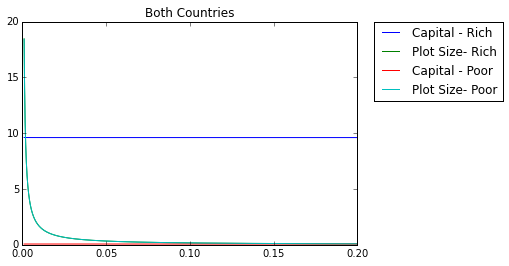

In [24]:
plt.plot(ys, ks, label="Capital - Rich")
plt.plot(ys, thetas, label="Plot Size- Rich")
plt.plot(ys2, ks2, label="Capital - Poor")
plt.plot(ys2, thetas2, label="Plot Size- Poor")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0.0,0.2)
plt.title("Both Countries")
plt.show()

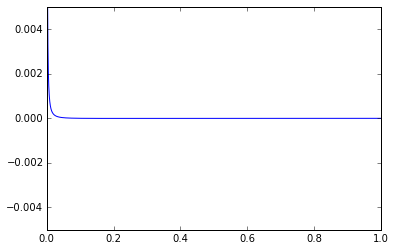

In [99]:
plt.plot(ys, (thetas-thetas2))
plt.xlim(0, 1)
plt.ylim(-0.005,0.005)
plt.show()

array([  1.84567854e+01,   1.84527983e+01,   1.84488114e+01, ...,
         6.73627462e-03,   4.36936867e-03,   1.76654339e-03])

Plot size ($\theta$)

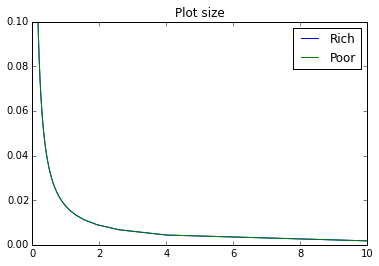

In [89]:
plt.plot(ys, thetas, label="Rich")
plt.plot(ys2, thetas2, label="Poor")
plt.legend(loc=1)
#plt.xlim(8,10)
plt.ylim(0,0.1)
plt.title("Plot size")
plt.show()

Land quality ($x$)

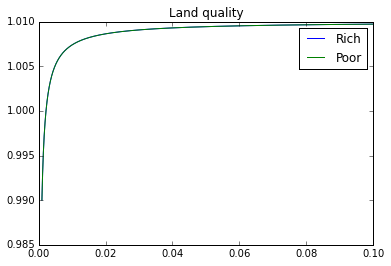

In [26]:
plt.plot(ys, xs, label="Rich")
plt.plot(ys2, xs2, label="Poor")
plt.legend(loc=1)
plt.xlim(0,0.1)
plt.title("Land quality")
plt.show()

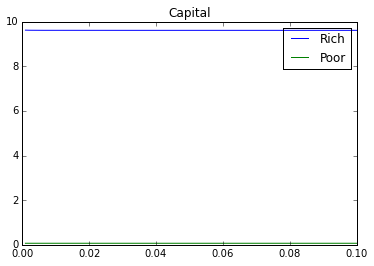

In [27]:
plt.plot(ys, ks, label="Rich")
plt.plot(ys2, ks2, label="Poor")
plt.legend(loc=1)
plt.xlim(0,0.1)
plt.title("Capital")
plt.show()

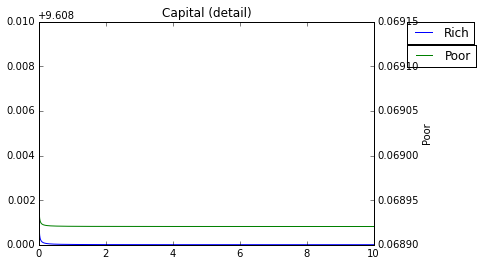

In [28]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.plot(ys, ks, label="Rich")
plt.xlim(min(ys),max(ys))

ax2 = ax1.twinx()
plt.plot(ys2, ks2, label="Poor", c='g')
ax2.set_ylabel('Poor')

ax1.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.065, 0.95), loc=2, borderaxespad=1)
plt.xlim(min(ys),max(ys))
plt.title("Capital (detail)")
plt.show()

## Extra bit: Distributions

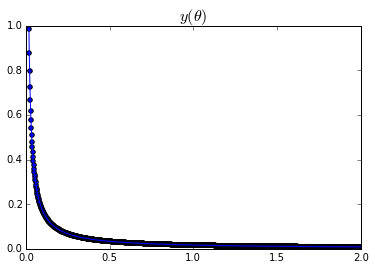

In [29]:
from scipy.interpolate import PchipInterpolator

# It is necessay for interpolation to order theta in ascending order
sateht = thetas[::-1]
sy = ys[::-1]
y_spl = PchipInterpolator(thetas[::-1], ys[::-1])
plt.plot(thetas, y_spl(thetas))
plt.scatter(thetas,ys)
plt.xlim(0,2)
plt.ylim(0,1)
plt.title("$y (\\theta)$", size=16)
plt.show()

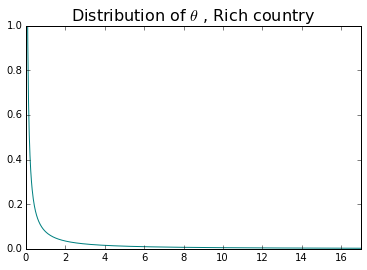

In [30]:
theta_grid  = np.linspace(min(thetas), max(thetas), 1000)
theta_dis = []
for th in theta_grid:
    theta_dis.append((firms.evaluate_pdf(y_spl(th),norm=False)*abs((y_spl.derivative()(th)))))
plt.plot(theta_grid, theta_dis, c='teal')
plt.xlim(0,17)
plt.ylim(0,1)
plt.title("Distribution of $\\theta$ , Rich country", size=16)
plt.show()


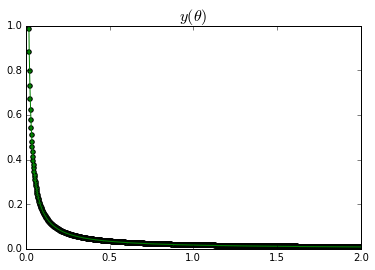

In [31]:
sateht2 = thetas2[::-1]
sy2 = ys2[::-1]
y_spl_P = PchipInterpolator(thetas2[::-1], ys2[::-1])
plt.plot(thetas2, y_spl_P(thetas2), c='g')
plt.scatter(thetas2,ys2, c='g')
plt.xlim(0,2)
plt.ylim(0,1)
plt.title("$y (\\theta)$", size=16)
plt.show()

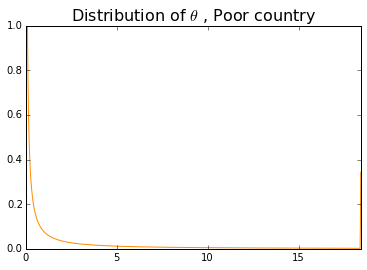

In [32]:
theta_grid2  = np.linspace(min(thetas2), max(thetas2), 1000)
theta_dis2 = []
for th in theta_grid:
    theta_dis2.append((firms.evaluate_pdf(y_spl_P(th),norm=False)*abs((y_spl_P.derivative()(th)))))
plt.plot(theta_grid2, theta_dis2, c='darkorange')
plt.xlim(min(thetas2),max(thetas2))
plt.ylim(0,1)
plt.title("Distribution of $\\theta$ , Poor country", size=16)
plt.show()

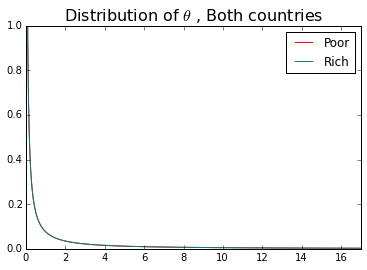

In [90]:
plt.plot(theta_grid2, theta_dis2, c='r', label='Poor')
plt.plot(theta_grid, theta_dis, c='teal', label='Rich')

plt.legend(loc='best')
plt.xlim(0,17)
plt.ylim(0,1)
plt.title("Distribution of $\\theta$ , Both countries", size=16)
plt.show()

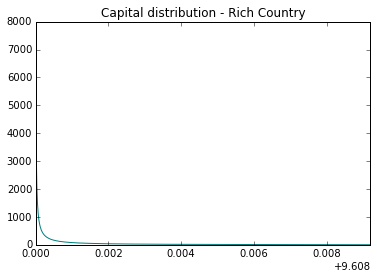

In [55]:
k_range = np.linspace(min(ks), max(ks), 1000)
k_range2 = np.linspace(min(ks2), max(ks2), 1000)

y_k = PchipInterpolator(ks[::-1], ys[::-1])
y_k2 = PchipInterpolator(ks2[::-1], ys2[::-1])
k_dis = []
k_dis2 = []

for k in k_range:
    k_dis.append(firms.evaluate_pdf(y_k(k),norm=False)*abs((y_k.derivative()(k))))
for k in k_range2:
    k_dis2.append(firms.evaluate_pdf(y_k2(k),norm=False)*abs((y_k2.derivative()(k))))

plt.plot(k_range, k_dis, c='teal', label='Rich')
plt.xlim(min(ks),max(ks))
plt.title("Capital distribution - Rich Country")
plt.show()

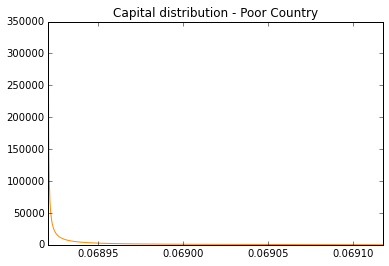

In [58]:
plt.plot(k_range2, k_dis2, c='darkorange', label='Poor')
plt.xlim(min(ks2),max(ks2))
plt.title("Capital distribution - Poor Country")
plt.show()

In [59]:
k_ratio =[]
k_ratio2 = []
for i in range(len(ks)):
    k_ratio.append(ks[i]/thetas[i])
    k_ratio2.append(ks2[i]/thetas2[i])
np.mean(k_ratio), np.mean(k_ratio2)

(7.0354116794498269, 0.050466255997961902)

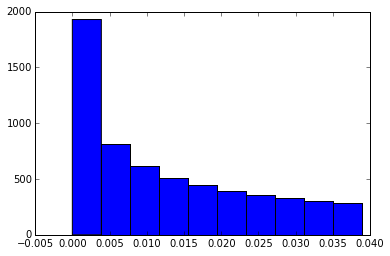

In [95]:
plt.hist(thetas-thetas2)
plt.show()

In [ ]:
# # # # # # # # # # # # # # # # # # # # Use in case thetas not sorted *not the case here* # # # # # # # # # # # # # # # # 
def get_cdf(thetas_fm,xs_fm):
    '''
    Gets the cdf value of a given firm size, by interpolating the implied distribution from the results of solving the model.
    
    Parameters:
    -----------
    thetas_fm: thetas from model (np.array or similar)
    xs_fm: xs grid points from model (np.array or similar)
    
    Returns:
    --------
    An executable numeric function, that omits values out of range (scipy.interpolate.interpolate.interp1d).
    
    '''

    n_thetas = dict(zip(list(map(str, range(0,len(thetas_fm)))),thetas_fm))
    sort_thetas = sorted(n_thetas.items(), key=operator.itemgetter(1))
    theta_range = sorted(thetas_fm)

    # Using the pdf of workers
    pdf_x = pdf_workers(xs_fm)        # calculates pdf of xs in one step
    n_pdf_x = dict(enumerate(pdf_x))  # creates a dictionary where the keys are the #obs of x
    pdf_theta_hat = np.empty(0)
    for pair in sort_thetas:
        index = int(pair[0])
        pdf_theta_hat  = np.hstack((pdf_theta_hat ,(n_pdf_x[index]/pair[1])))

    cdf_theta_hat  = np.cumsum(pdf_theta_hat )           # Backing up model cdf
    cdf_theta_hat  = cdf_theta_hat /cdf_theta_hat[-1]    # Normilization of the model cdf
    cdf_theta_int = interp1d(np.log(theta_range),cdf_theta_hat,bounds_error=False)
    
    return cdf_theta_int